In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
import logging

sys.path.insert(0,'../scripts/')
from log_helper import Logger_Class
from prophet_helper import Fb_prophet
import io
import dvc.api





In [2]:
log_obj = Logger_Class('../logs/prophet.log').get_logger()

In [3]:
# repo = 'https://github.com/nahomHmichael/Rossman-Pharmaceutical-Sales-Pridiction'
# rev = 'bc0981'
# path='data/train_store_data.csv'
# data_train =  dvc.api.get_url(path=path,repo=repo,rev=rev)
# train = pd.read_csv(io.StringIO(data_train),low_memory=False)

In [4]:
train = pd.read_csv('../data/train.csv', low_memory=False)
test = pd.read_csv('../data/test.csv', low_memory=False)
store = pd.read_csv('../data/store.csv',low_memory=False)
log_obj.info('loaded datasets!')

In [5]:
train.head

<bound method NDFrame.head of          Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0            1          5  2015-07-31   5263        555     1      1   
1            2          5  2015-07-31   6064        625     1      1   
2            3          5  2015-07-31   8314        821     1      1   
3            4          5  2015-07-31  13995       1498     1      1   
4            5          5  2015-07-31   4822        559     1      1   
...        ...        ...         ...    ...        ...   ...    ...   
1017204   1111          2  2013-01-01      0          0     0      0   
1017205   1112          2  2013-01-01      0          0     0      0   
1017206   1113          2  2013-01-01      0          0     0      0   
1017207   1114          2  2013-01-01      0          0     0      0   
1017208   1115          2  2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday  
0                  0              1  
1                  0         

In [6]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [7]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
# data extraction
train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['WeekOfYear'] = train['Date'].dt.weekofyear

# adding new variable
#train['SalePerCustomer'] = train['Sales']/train['Customers']
#train['SalePerCustomer'].describe()

In [9]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31


In [10]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
Year             0
Month            0
Day              0
WeekOfYear       0
dtype: int64

In [11]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [12]:

# Closed stores and zero sales stores
#train[(train.Open == 0) & (train.Sales == 0)].shape

In [13]:
# opened stores with zero sales
#zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
#print("In total: ", zero_sales.shape)

In [14]:
# dropping closed stores and days with no sale for forcasting 
#train = train[(train["Open"] != 0) & (train['Sales'] != 0)]
#train.shape

In [15]:
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [16]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [17]:
store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].mode, inplace = True)
store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].mode, inplace = True)
store['Promo2SinceWeek'].fillna(store['Promo2SinceWeek'].mode, inplace = True)
store['Promo2SinceYear'].fillna(store['Promo2SinceYear'].mode, inplace = True)
store['PromoInterval'].fillna(store['PromoInterval'].mode, inplace = True)
store.isnull().values.any()

False

In [18]:
# no promo = no information about the promo?
#no_promo= store[pd.isnull(store.Promo2SinceWeek)]
#no_promo[no_promo.Promo2 != 0].shape

In [19]:
# replace NA's by 0
#store.fillna(0, inplace = True)

In [20]:
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("Merged df shape: ", train_store.shape)

Merged df shape:  (1017209, 22)


In [21]:
def preprocessDf(df):
     # remove closed stores and those with no sales
    df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

    # sales for the store number 1 (StoreType C)
    sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

    # reverse to the order: from 2013 to 2015
    sales = sales.sort_index(ascending = False)

    # to datetime64
    sales['Date'] = pd.DatetimeIndex(sales['Date'])
    sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
    # plot daily sales
    ax = sales.set_index('ds').plot(figsize = (12, 4), color = "blue")
    ax.set_ylabel('Daily Number of Sales')
    ax.set_xlabel('Date')
    plt.show()
    return sales 

# modeling holidays
def modeling_holiday(df):
    # create holidays dataframe
    state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
    school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

    state = pd.DataFrame({'holiday': 'state_holiday',
                          'ds': pd.to_datetime(state_dates)})
    school = pd.DataFrame({'holiday': 'school_holiday',
                          'ds': pd.to_datetime(school_dates)})

    holidays = pd.concat((state, school))
    return holidays
    

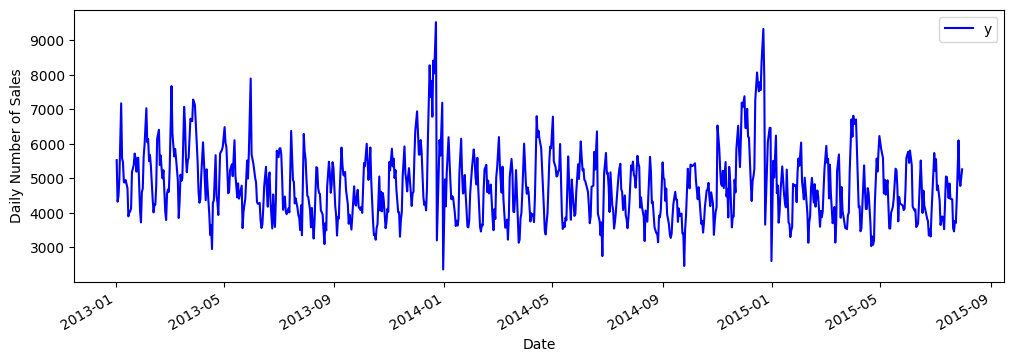

In [22]:
sales = preprocessDf(train_store)

In [23]:
holidays = modeling_holiday(train)

In [24]:
prophet = Fb_prophet(sales,holidays)

16:09:57 - cmdstanpy - INFO - Chain [1] start processing
16:09:58 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
week=3 #no of weeks we want to forcast
fd = prophet.getFuture_dates(week)
predict = prophet.get_predicate()


<AxesSubplot:xlabel='Date', ylabel='Forecast_Sales'>

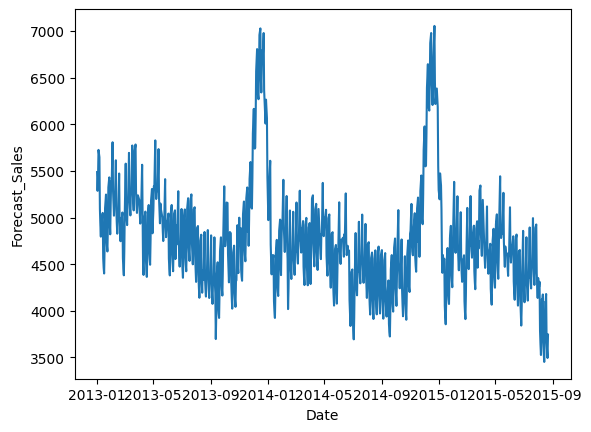

In [26]:
sns.lineplot(x=predict['Date'],y=predict['Forecast_Sales'],data=predict)

In [27]:
#prophet.get_performanceMetrics()


<AxesSubplot:xlabel='Date', ylabel='Forecast_Sales'>

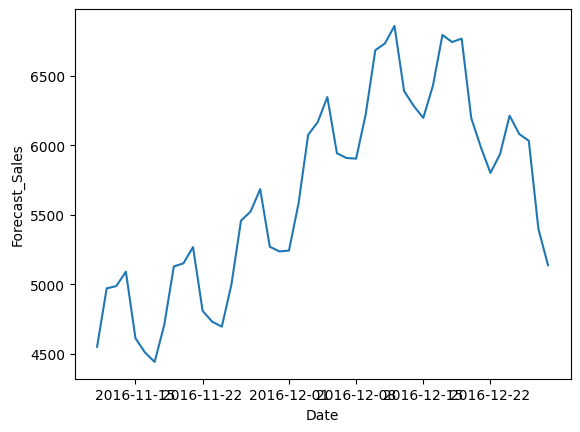

In [28]:
data_f = pd.DataFrame()
start_date= '2016-11-11'
end_date= '2016-12-25'
data_f['ds'] = pd.date_range(start_date, periods = 48, freq ='D') 

p = prophet.model.predict(data_f)
fc = p[['ds', 'yhat']].rename(columns = {'ds': 'Date', 'yhat': 'Forecast_Sales'})
sns.lineplot(x=fc['Date'],y=fc['Forecast_Sales'],data=fc)

Saving model successful!!!


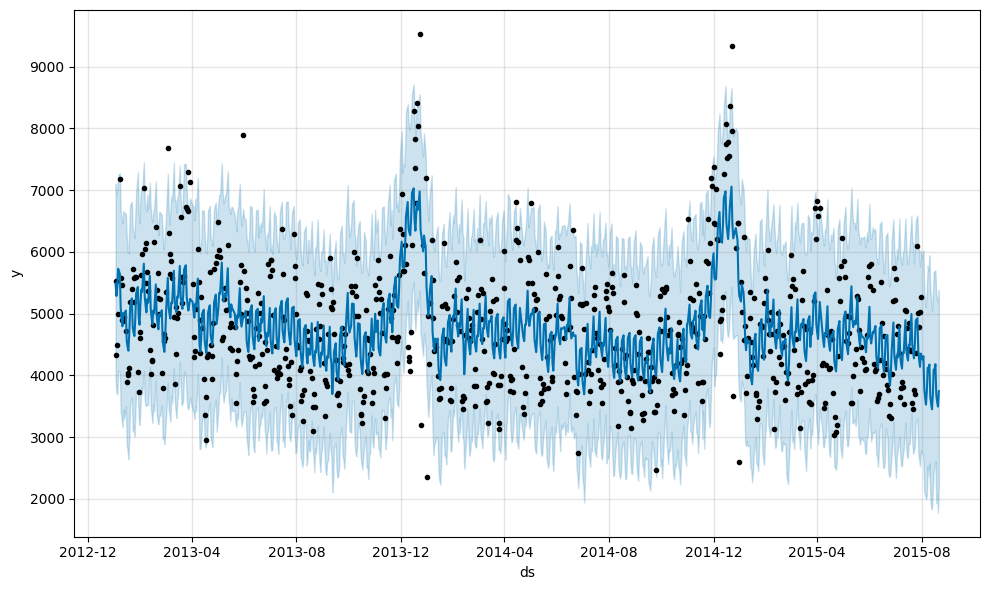

In [29]:
prophet.eff_modlel()
filename = prophet.save_model()